In [1]:
!pip install rasterio
!pip install GDAL

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 57.4 MB/s eta 0:00:00


In [3]:
import joblib
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


def train_optimized_xgboost(data_path):
    # Đọc dữ liệu
    data = pd.read_csv(data_path)

    # Encode nhãn
    le = LabelEncoder()
    data['label'] = le.fit_transform(data['label'])

    # Tách features và target
    features = ['Long', 'Lat', 'B2', 'B3', 'B4', 'B5', 'B8', 'B8A', 'B11', 'B12',
                'NDVI', 'NDWI', 'NDBI', 'NDMI', 'BSI']
    X = data[features]
    y = data['label']

    # Tách train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Định nghĩa grid search parameters
    param_grid = {
        'max_depth': [5, 6],
        'learning_rate': [0.01, 0.1],
        'n_estimators': [150, 200],
        'min_child_weight': [1, 3],
        'gamma': [0, 0.1],
        'subsample': [0.8, 0.9],
        'colsample_bytree': [0.8]
    }

    # Khởi tạo model cơ bản
    base_model = XGBClassifier(
        objective='multi:softmax',
        eval_metric='mlogloss',
        tree_method='hist',
        device='cuda',  # Sử dụng GPU nếu có
        random_state=42
    )

    # Thực hiện Grid Search với cross-validation
    grid_search = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=2
    )

    # Fit GridSearchCV để tìm best parameters
    grid_search.fit(X_train, y_train)

    # Lấy best parameters từ GridSearchCV
    best_params = grid_search.best_params_
    print("\nBest parameters:", best_params)

    # Khởi tạo lại model với các best parameters
    best_model = XGBClassifier(
        **best_params,
        objective='multi:softmax',
        eval_metric='mlogloss',
        tree_method='hist',
        device='cuda',  # Sử dụng GPU nếu có
        random_state=42
    )

    # Huấn luyện model không sử dụng early stopping
    best_model.fit(X_train, y_train, verbose=True)

    # Đánh giá model
    y_pred = best_model.predict(X_test)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    # Vẽ confusion matrix
    plt.figure(figsize=(12, 8))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Phân tích feature importance
    importance_df = pd.DataFrame({
        'feature': features,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=importance_df)
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()

    return best_model, le

# Gọi hàm huấn luyện



Fitting 5 folds for each of 64 candidates, totalling 320 fits

Best parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:58:54] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)



Classification Report:
                  precision    recall  f1-score   support

     barren land       1.00      1.00      1.00       700
        cropland       0.99      1.00      1.00      1040
          forest       1.00      0.99      1.00       940
      open water       1.00      0.99      1.00      1500
residential land       1.00      1.00      1.00      1560
      rice paddy       1.00      1.00      1.00      1220

        accuracy                           1.00      6960
       macro avg       1.00      1.00      1.00      6960
    weighted avg       1.00      1.00      1.00      6960



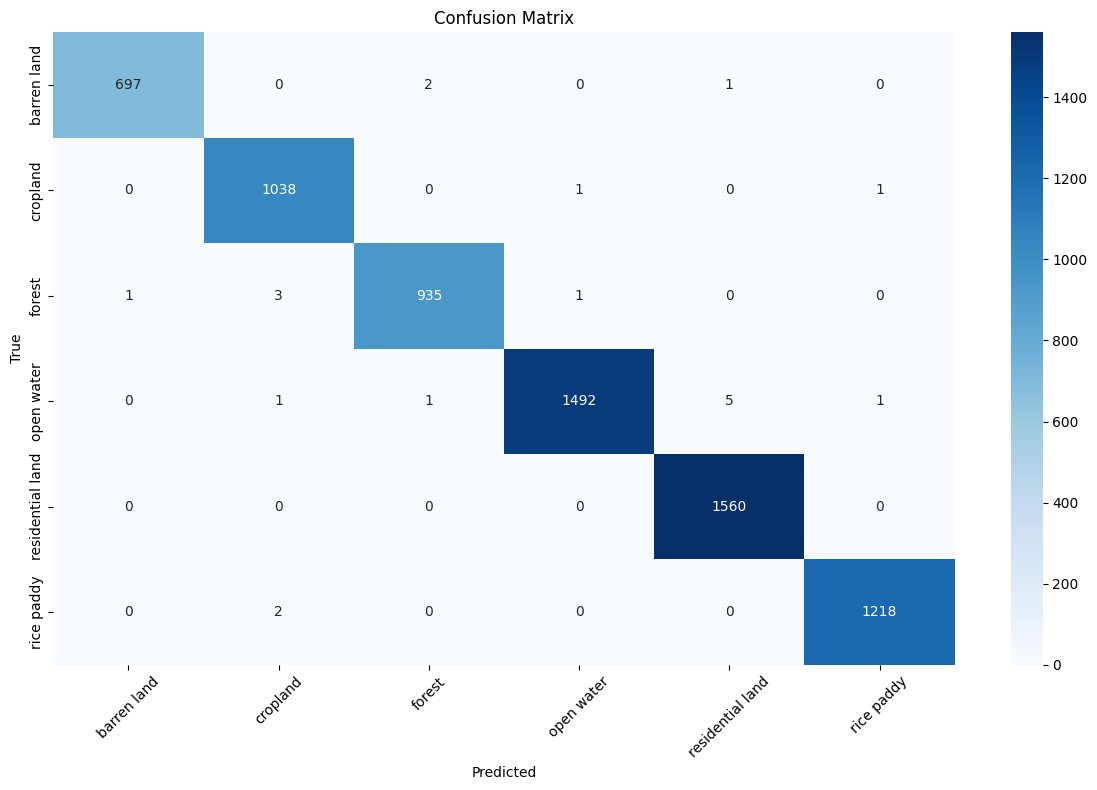

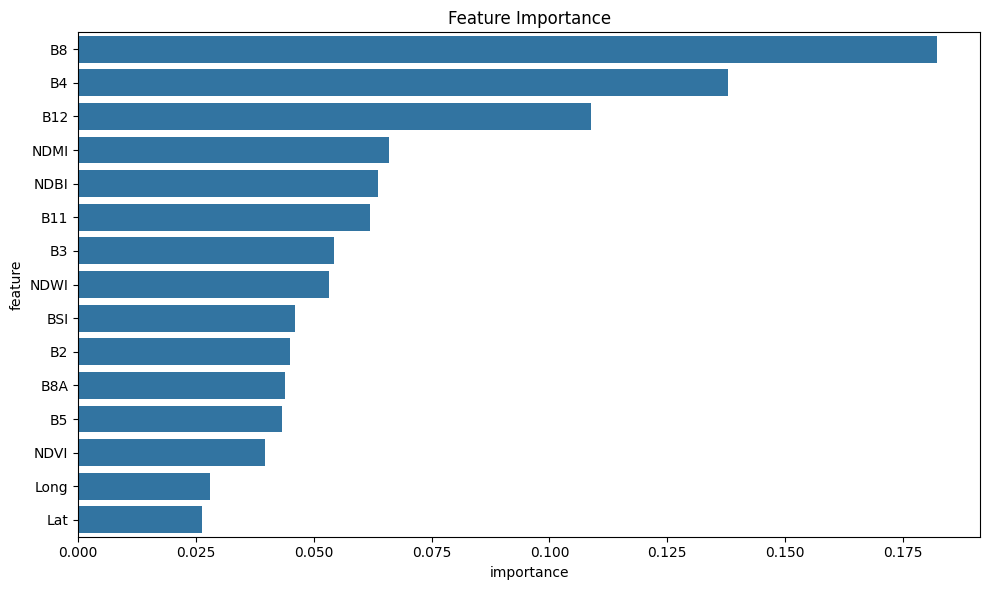

In [4]:
model, label_encoder = train_optimized_xgboost('/content/datavoicacbandmauvachiso.csv')

In [8]:
model_filename = "xgboost_model.joblib"  # Đặt tên file model
joblib.dump(model, model_filename)
print(f"Model đã được lưu vào: {model_filename}")

Model đã được lưu vào: xgboost_model.joblib


In [12]:
import rasterio # Importing rasterio here
from rasterio.windows import Window # Importing Window
from concurrent.futures import ThreadPoolExecutor # Importing ThreadPoolExecutor

In [13]:
def predict_block(args):
    """Hàm helper để xử lý từng block"""
    block_data, model, features_list, x_coords, y_coords = args

    # Chuyển đổi dữ liệu về dạng 2D (số pixel, số feature)
    height, width, _ = block_data.shape
    block_reshaped = block_data.reshape(height * width, -1)

    # Ghép thêm kinh độ và vĩ độ vào block
    long_lat = np.column_stack((x_coords.ravel(), y_coords.ravel()))
    full_data = np.hstack((long_lat, block_reshaped))

    # Dự đoán và reshape lại kết quả
    predictions = model.predict(full_data)
    return predictions.reshape(height, width)

def create_landcover_map(image_path, model, output_path, block_size=1024):
    """Tạo bản đồ lớp phủ với xử lý đa luồng và tối ưu bộ nhớ"""
    with rasterio.open(image_path) as src:
        # Copy metadata cho file output
        meta = src.meta.copy()
        meta.update({
            'count': 1,
            'dtype': 'uint8',
            'nodata': 0
        })

        # Đọc các band cần thiết
        features_list = ['B2', 'B3', 'B4', 'B5', 'B8', 'B8A', 'B11', 'B12']
        band_indices = [src.descriptions.index(band) + 1 if band in src.descriptions
                        else i + 1 for i, band in enumerate(features_list)]

        # Tạo file output
        with rasterio.open(output_path, 'w', **meta) as dst:
            n_blocks_y = int(np.ceil(src.height / block_size))
            n_blocks_x = int(np.ceil(src.width / block_size))

            blocks_to_process = []
            for iy in range(n_blocks_y):
                for ix in range(n_blocks_x):
                    # Tính offset và kích thước của block
                    y_off = iy * block_size
                    x_off = ix * block_size
                    height = min(block_size, src.height - y_off)
                    width = min(block_size, src.width - x_off)

                    # Đọc dữ liệu block
                    window = Window(x_off, y_off, width, height)
                    block_data = src.read(band_indices, window=window)
                    block_data = np.transpose(block_data, (1, 2, 0))

                    # Tính tọa độ Long và Lat cho từng pixel trong block
                    x_coords, y_coords = np.meshgrid(
                        np.linspace(x_off, x_off + width - 1, width),
                        np.linspace(y_off, y_off + height - 1, height)
                    )

                    # Tính các chỉ số phổ
                    ndvi = (block_data[:, :, 4] - block_data[:, :, 2]) / (
                        block_data[:, :, 4] + block_data[:, :, 2] + 1e-8
                    )
                    ndwi = (block_data[:, :, 1] - block_data[:, :, 4]) / (
                        block_data[:, :, 1] + block_data[:, :, 4] + 1e-8
                    )
                    ndbi = (block_data[:, :, 6] - block_data[:, :, 4]) / (
                        block_data[:, :, 6] + block_data[:, :, 4] + 1e-8
                    )
                    ndmi = (block_data[:, :, 4] - block_data[:, :, 6]) / (
                        block_data[:, :, 4] + block_data[:, :, 6] + 1e-8
                    )
                    bsi = (
                        (block_data[:, :, 6] + block_data[:, :, 2])
                        - (block_data[:, :, 4] + block_data[:, :, 0])
                    ) / (
                        (block_data[:, :, 6] + block_data[:, :, 2])
                        + (block_data[:, :, 4] + block_data[:, :, 0])
                        + 1e-8
                    )

                    # Kết hợp tất cả features lại
                    full_block_data = np.dstack((
                        block_data,
                        ndvi[:, :, np.newaxis],
                        ndwi[:, :, np.newaxis],
                        ndbi[:, :, np.newaxis],
                        ndmi[:, :, np.newaxis],
                        bsi[:, :, np.newaxis]
                    ))

                    # Thêm block vào danh sách xử lý
                    blocks_to_process.append(
                        (full_block_data, model, features_list, x_coords, y_coords)
                    )

            # Xử lý đa luồng
            with ThreadPoolExecutor(max_workers=4) as executor:
                results = list(executor.map(predict_block, blocks_to_process))

            # Ghi kết quả vào file output
            for idx, (iy, ix) in enumerate(np.ndindex(n_blocks_y, n_blocks_x)):
                y_off = iy * block_size
                x_off = ix * block_size
                height = min(block_size, src.height - y_off)
                width = min(block_size, src.width - x_off)

                window = Window(x_off, y_off, width, height)
                dst.write(results[idx].astype('uint8'), 1, window=window)

# Gọi hàm với file đầu vào và đầu ra
create_landcover_map(
    '/content/test1-0000000000-0000013312.tif',
    model,
    'outputTIFFimage.tif',
    block_size=1024
)
